In [2]:
import numpy as np 
import pandas as pd


In [4]:
prp = pd.read_csv("WD_PRP_Projections.csv")

# See all education level labels
sorted(prp["education"].unique())

['Bachelor',
 'Incomplete Primary',
 'Lower Secondary',
 'Master and higher',
 'No Education',
 'Post Secondary',
 'Primary',
 'Short Post Secondary',
 'Upper Secondary']

In [4]:
# Tertiary / post-secondary categories
TERTIARY_LEVELS = [
    "Bachelor",
    "Master and higher",
    "Post Secondary",
    "Short Post Secondary"
]

# Filter only rows with tertiary education
tertiary = prp[prp["education"].isin(TERTIARY_LEVELS)]

# Keep youth ages
youth_tertiary = tertiary[tertiary["age"].isin(["15-19", "20-24"])]

# Compute % of youth with tertiary (simple average)
tertiary_share = (
    youth_tertiary.groupby(["iso3", "year"])["prop"]
    .sum()         # sum because these are multiple tertiary categories
    .reset_index()
    .rename(columns={"prop": "tertiary_percent"})
)

print(tertiary_share.head())

  iso3  year  tertiary_percent
0  ABW  2025            176.26
1  ABW  2030            187.63
2  ABW  2035            198.23
3  AFG  2025            144.51
4  AFG  2030            178.40


In [5]:
# Question 1

pop = pd.read_csv("UN_Pop_Projections.csv")
mys = pd.read_csv("WD_MYS_Projections.csv")
prp = pd.read_csv("WD_PRP_Projections.csv")

In [6]:
# -------------------------
# 2. FILTER YOUTH AGES
# -------------------------
YOUTH_AGES_POP = ["15-19", "20-24"]
YOUTH_AGES_EDU = ["15-19", "20-24"]

pop_youth = pop[pop["age"].isin(YOUTH_AGES_POP)]
mys_youth = mys[mys["age"].isin(YOUTH_AGES_EDU)]
prp_youth = prp[prp["age"].isin(YOUTH_AGES_EDU)]

In [7]:
# -------------------------
# 3. CREATE INCOME GROUP LABEL
# (LIC, LMC, UMC, HIC)
# -------------------------
def assign_income_group(row):
    for g in ["LIC", "LMC", "UMC", "HIC"]:
        if row[g] == True:
            return g
    return None

pop_youth["income_group"] = pop_youth.apply(assign_income_group, axis=1)
mys_youth["income_group"] = mys_youth.apply(assign_income_group, axis=1)
prp_youth["income_group"] = prp_youth.apply(assign_income_group, axis=1)

In [8]:
# -------------------------
# 4. YOUTH POPULATION GROWTH 2025 → 2035
# -------------------------
pop_summary = (
    pop_youth.groupby(["income_group", "year"])["population"]
    .sum()
    .reset_index()
)

pop_2025 = pop_summary[pop_summary["year"] == 2025]
pop_2035 = pop_summary[pop_summary["year"] == 2035]

pop_growth = pop_2025.merge(pop_2035, on="income_group", suffixes=("_2025", "_2035"))
pop_growth["youth_pop_growth_pct"] = (
    (pop_growth["population_2035"] - pop_growth["population_2025"])
    / pop_growth["population_2025"]
) * 100

In [9]:
# -------------------------
# 5. MYS GROWTH 2025 → 2035
# -------------------------
mys_summary = (
    mys_youth.groupby(["income_group", "year"])["mys"]
    .mean()
    .reset_index()
)

mys_2025 = mys_summary[mys_summary["year"] == 2025]
mys_2035 = mys_summary[mys_summary["year"] == 2035]

mys_growth = mys_2025.merge(mys_2035, on="income_group", suffixes=("_2025", "_2035"))
mys_growth["mys_growth"] = mys_growth["mys_2035"] - mys_growth["mys_2025"]

EDUCATION PRESSURE INDEX:
How fast the youth population is growing relative to how fast education levels (MYS) are improving.

In [12]:
# -------------------------
# 7. EDUCATION PRESSURE INDEX
# -------------------------
final = pop_growth.merge(mys_growth, on="income_group")
final["education_pressure_index"] = (
    final["youth_pop_growth_pct"] / final["mys_growth"]
)


final = final.drop(columns=[col for col in final.columns if col.startswith("year_")])

print(final)

  income_group  population_2025  population_2035  youth_pop_growth_pct  \
0          HIC     4.240785e+06     4.214800e+06             -0.612755   
1          LIC     3.356140e+06     4.205648e+06             25.312078   
2          LMC     1.500420e+07     1.572809e+07              4.824551   
3          UMC     9.855159e+06     1.012037e+07              2.691117   

    mys_2025   mys_2035  mys_growth  education_pressure_index  
0  10.943259  10.912134   -0.031124                 19.687294  
1   6.894987   7.341880    0.446893                 56.640088  
2   8.930367   9.177820    0.247453                 19.496813  
3  10.476813  10.533487    0.056673                 47.484708  


LICs have the highest pressure

Youth population exploding

Education improving slowly
→ System overwhelmed
→ growing skills gap

2. LMCs have moderate pressure

Youth growing, but manageable

Education improving faster than LICs
→ Balanced growth (Scenario B)

3. UMCs have high pressure for a different reason

Youth barely grows

But MYS barely increases either
→ Education stagnation slows skill upgrading (Scenario C)

4. HICs have low structural pressure

Youth declining

Education saturated

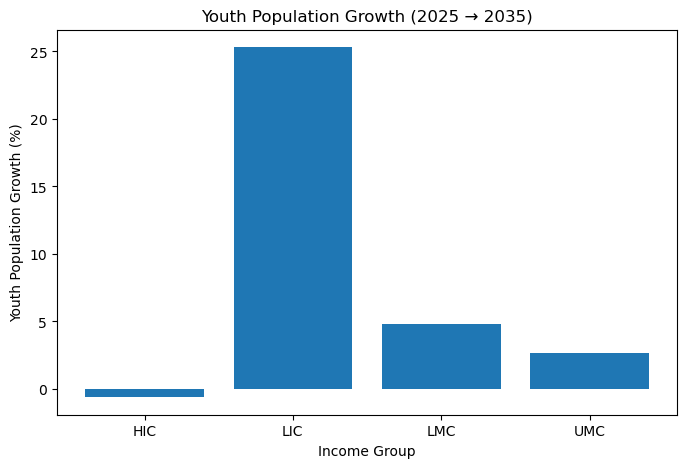

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(final["income_group"], final["youth_pop_growth_pct"])
plt.xlabel("Income Group")
plt.ylabel("Youth Population Growth (%)")
plt.title("Youth Population Growth (2025 → 2035)")
plt.show()

In [14]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
fig = px.bar(
    final,
    x="income_group",
    y="youth_pop_growth_pct",
    title="Youth Population Growth (2025 → 2035)",
    labels={"income_group": "Income Group", "youth_pop_growth_pct": "Youth Population Growth (%)"},
    text="youth_pop_growth_pct"
)
fig.update_traces(textposition='outside')
fig.show()
